# The Enigma of Complexity Survey

## A brief overview of the back end

![alt text](FlowChart.png "Title")

In [10]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
# from survey import Match, Lomas, OrgsDb, LineDrawings

## Dataset
We start with data that we want to evaluate (images in our case)

In [110]:
# Create an empty dataset
data = []

# Populate teh dataset
for i in range(20):
    d = [1500, 350, '']
    data.append(d)

# put the data into a pandas dataframe so it's easier to work with
test_db = pd.DataFrame(data, columns=['rating','RD','matches'])
test_db.head()

,rating,RD,matches
0,1500,350,
1,1500,350,
2,1500,350,
3,1500,350,
4,1500,350,


What we wanted to do was to rank these images in terms of their complexity and aesthetics, as perceived by people. There are several ways to do this, like showing them in isolation and asking for a direct rating. This causes some problems, like participants' fatigue and uncertainties due to the lack of context.

As you know, we went with a pairwise comparison approach. This makes things faster and less ambiguous.

The question then is how do we translate those comparisons into a ranking, so by the end of the process we have an idea of which images are more complex and/or liked.

## Update ratings function
This function looks at the result of a match and the ratings and RDs of an individual and its oponent, and then calculates their new ratings and RDs based on who _'won'_ the match


In [102]:
# def updateRating(s, r, rd, r_other, rd_other):
def updateRating(s, winner, loser):
    # s is the result of comparison (1 if selected, .5 if can't decide, 0 if not selected)
    
    r = float(winner['rating'])
    rd = float(winner['RD'])
    r_other = float(loser['rating'])
    rd_other = float(loser['RD'])

    
    q = 0.00575646273   #constant (magic number?)
    
    
    g_rd_other = 1/math.sqrt(1 + (3 * (q**2)*(rd_other**2)/pow(math.pi,2)))

    # Expected outcome
    e_exp = -g_rd_other * (r - r_other)/400
    e = 1/(1 + pow(10,e_exp))
    
    d_square = pow(pow(q,2) * pow(g_rd_other,2)*e*(1-e),-1)
    
    r_new = r + (q/(1/(pow(rd,2)+(1/d_square))) * g_rd_other * (s - e))
    rd_new = math.sqrt(pow((1/math.pow(rd,2))+(1/d_square),-1))
    return r_new, rd_new

## Test the function

In [113]:
a = test_db.sample(n=1)
b = test_db.sample(n=1)
while a.index[0] == b.index[0]:
    b = test_db.sample(n=1)
updated = updateRating(0.5, a, b)
print(f"New rating: {round(updated[0],3)}, new RD: {round(updated[1],3)}")

New rating: 1500.0, new RD: 290.231


## Matches or 'games'
- Two database entries are selected randomly to compete aganinst each other.
- The winner is determined using their rating as a probability of success.

### First create a match function
This function takes two entries from the database and randomly selects the winner using their ratings as probability

In [81]:
def match(contenders):
    
    #normalise ratings
    ratings = contenders['rating'].tolist()
    norm_ratings = [r/max(ratings) for r in ratings]
    winner = contenders.sample(weights=norm_ratings)
    return winner

### Reset test database 

In [118]:
test_db = pd.DataFrame(data, columns=['rating','RD','matches'])

### Store data as matches unfold

In [119]:
avg_RD = []
rating_var = []
ind_r = []


### Simulate a bunch of matches

In [122]:
for i in range(1000):
    # select contenders
    contenders = test_db.sample(n=2)
    #simulate match    
    winner = match(contenders)
    winner_index = winner.index[0]
    loser = contenders.drop(winner_index)
    loser_index = loser.index[0]
    
    #add match results to database
    test_db.loc[winner_index,'matches']+=f'{loser_index}:1;'
    test_db.loc[loser_index,'matches']+=f'{winner_index}:0;'
    
    #update ratings
    winner_nr, winner_nRD = updateRating(1,winner, loser)
    loser_nr, loser_nRD = updateRating(0,loser,winner)
    
    test_db.loc[winner_index,'rating'] = winner_nr
    test_db.loc[winner_index,'RD'] = winner_nRD
    
    test_db.loc[loser_index,'rating'] = loser_nr
    test_db.loc[loser_index,'RD'] = loser_nRD
    
#     a = contenders[:1]
#     b = contenders[1:]
    #record average RD
    avg = np.mean(np.asarray(test_db['RD']))
    avg_RD.append(avg)
    
    #record rating variance
    rating_var.append(np.std(np.asarray(test_db['rating'])))
    
    #record rating of single entry
    ind_r.append(float(test_db.loc[0,'rating']))
        
#     if avg <= 150:
#         break
    
        

    
#     print(contenders)
#     print(a['rating'])
#     print(b.index[0])

,rating,RD,matches
0,1504.174534,37.157554,3:0;3:0;6:0;3:0;17:1;1:0;14:1;17:1;17:0;7:1;11...
1,1538.198226,35.979238,8:0;18:0;5:0;12:1;19:1;4:1;13:0;0:1;7:0;17:1;6...
2,1523.464034,34.276176,12:1;14:1;18:1;11:1;16:1;17:1;8:1;6:0;13:1;11:...
3,1513.670700,33.796008,11:0;0:1;0:1;16:0;6:0;19:1;16:0;8:0;18:0;7:0;0...
4,1452.262495,33.599064,11:1;11:0;16:1;17:0;6:0;1:0;3:0;7:1;3:0;10:0;1...
5,1508.121454,35.010956,16:0;18:1;13:1;14:0;19:0;1:1;16:1;8:0;14:1;14:...
6,1451.589405,36.425141,3:1;8:1;18:1;0:1;2:1;15:1;4:1;3:0;13:1;17:1;18...
7,1459.980385,36.962704,17:1;3:1;3:1;4:0;1:1;19:1;2:1;14:0;0:0;11:0;17...
8,1524.217086,34.842966,12:1;1:1;9:0;17:1;6:0;9:0;3:1;2:0;16:1;5:1;11:...
9,1476.717970,34.482632,8:1;12:1;19:0;8:1;18:0;17:0;8:1;2:0;12:1;15:1;...


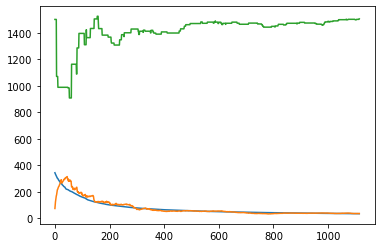

In [123]:
# print(avg_RD)
plt.plot(avg_RD)
plt.plot(rating_var)
plt.plot(ind_r)
test_db